In [48]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
import matplotlib.pyplot as plt

In [136]:
from utils import play
from qlearner import QPlayer
from tic_env import OptimalPlayer
import random
from collections import defaultdict
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# Fix seed for reproducibility
random.seed(0)
np.random.seed(0)

In [112]:
def save_stats(players, path):
    player_stats = []
    
    for player in players:
        
        stat = {
            'reward': player.avg_rewards,
            'm_opt': player.m_values['m_opt'],
            'm_rand': player.m_values['m_rand']
        }
        player_stats.append(stat)
        
    with open(path, 'wb') as npy:
        np.save(npy, player_stats)
        

In [113]:
def plot_average_rewards(stats_path, labels, log_every=250):
    try:
        with open(stats_path, 'rb') as npy:
            player_stats = np.load(npy, allow_pickle=True)
    except:
        print('File not found!')
        raise
        
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))

    game_ids = list(range(0, len(player_stats[0]['reward'])*log_every, log_every))
    for i, player in enumerate(player_stats):
        label = labels[i]
        ax.plot(game_ids, player['reward'], label=label)
    
    ax.set_title(f'Average reward per {log_every} games', fontsize=20, fontweight='bold')
    ax.set_xlabel('Game', fontsize=16)
    ax.set_ylabel('Reward', fontsize=16)
    ax.set_xlim([0, len(game_ids)*log_every])
    ax.legend(loc='lower right')
    ax.grid()

    plt.show()
    

In [130]:
def plot_m_values(stats_path, labels, test_every=250):
    try:
        with open(stats_path, 'rb') as npy:
            player_stats = np.load(npy, allow_pickle=True)
    except:
        print('File not found!')
        raise
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    game_ids = list(range(0, len(player_stats[0]['reward'])*test_every, test_every))
    for i, player in enumerate(player_stats):
        label = labels[i]
        axes[0].plot(game_ids, player["m_opt"], label=label)
        axes[1].plot(game_ids, player["m_rand"], label=label)

        
    axes[0].set_title(f'M_opt per {test_every} games', fontsize=20, fontweight='bold')
    axes[0].set_xlabel('Game', fontsize=16)
    axes[0].set_ylabel('M_opt', fontsize=16)
    axes[0].set_xlim([0, len(game_ids)*test_every])
    axes[0].legend()
    axes[0].grid()
    
    axes[1].set_title(f'M_rand per {test_every} games', fontsize=20, fontweight='bold')
    axes[1].set_xlabel('Game', fontsize=16)
    axes[1].set_ylabel('M_rand', fontsize=16)
    axes[1].set_xlim([0, len(game_ids)*test_every])
    axes[1].legend()
    axes[1].grid()

    plt.show()
    

### Q1

In [115]:
epsilons = [0.01, 0.1]
eps_q_players = []

for eps in epsilons:
    suboptimal_player = OptimalPlayer(epsilon=0.5)
    q_player = QPlayer(epsilon=eps, log_every=250)
    play(suboptimal_player, q_player, episodes=20000)
    eps_q_players.append(q_player)
    

save_stats(players=eps_q_players, path='answers/Q1.npy')


  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

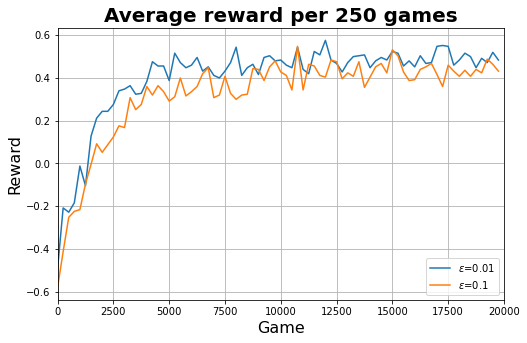

In [117]:
plot_average_rewards('answers/Q1.npy', labels=[f'$\epsilon$={eps}' for eps in epsilons])


### Q2

In [118]:
EPS_MIN = 0.1
EPS_MAX = 0.8
n_stars = [1, 100, 1000, 10000, 40000]
n_star_players = []


for n_star in n_stars:
    get_epsilon = lambda n, n_star=n_star: max(EPS_MIN, EPS_MAX * (1 - n / n_star))
    suboptimal_player = OptimalPlayer(epsilon=0.5)
    q_player = QPlayer(epsilon=get_epsilon, log_every=250)
    play(suboptimal_player, q_player, episodes=20000)
    n_star_players.append(q_player)
    
save_stats(players=n_star_players, path='answers/Q2.npy')
    

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

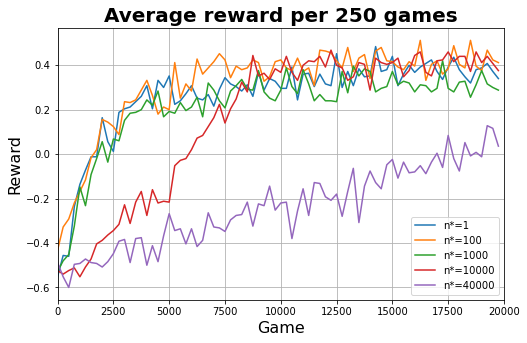

In [127]:
plot_average_rewards(stats_path='answers/Q2.npy', labels=[f'n*={n_star}' for n_star in n_stars])


### Q3

In [128]:
EPS_MIN = 0.1
EPS_MAX = 0.8
n_stars = [1, 100, 1000, 10000, 40000]
n_star_players = []

for n_star in n_stars:
    get_epsilon = lambda n, n_star=n_star: max(EPS_MIN, EPS_MAX * (1 - n / n_star))
    suboptimal_player = OptimalPlayer(epsilon=0.5)
    q_player = QPlayer(epsilon=get_epsilon, log_every=250, test_every=250)
    play(suboptimal_player, q_player, episodes=20000)
    n_star_players.append(q_player)
    
save_stats(players=n_star_players, path='answers/Q3.npy')


  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

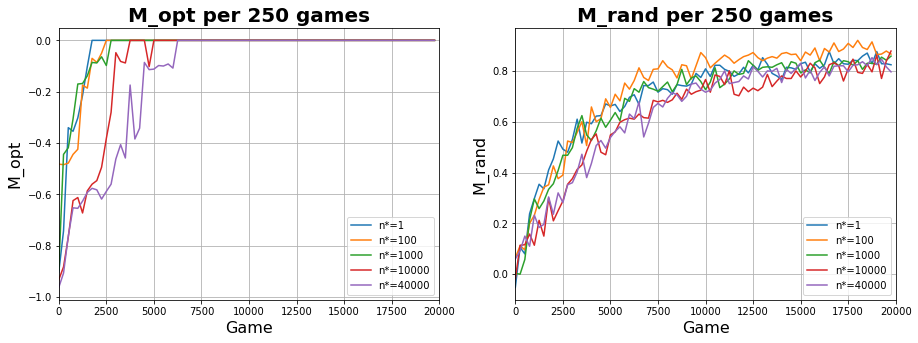

In [131]:
plot_m_values(stats_path='answers/Q3.npy', labels=[f"n*={n_star}" for n_star in n_stars])



### Q4

In [132]:
N_STAR = 100
EPS_MIN = 0.1
EPS_MAX = 0.8
get_epsilon = lambda n: max(EPS_MIN, EPS_MAX * (1 - n / N_STAR))

epsilons = [0, 0.01, 0.1, 0.25, 0.5, 0.75, 1]

eps_players = []

for eps in epsilons:
    other_player = OptimalPlayer(epsilon=eps)
    q_player = QPlayer(epsilon=get_epsilon, log_every=250, test_every=250)
    play(other_player, q_player, episodes=20000)
    eps_players.append(q_player)
    
save_stats(players=eps_players, path='answers/Q4.npy')

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

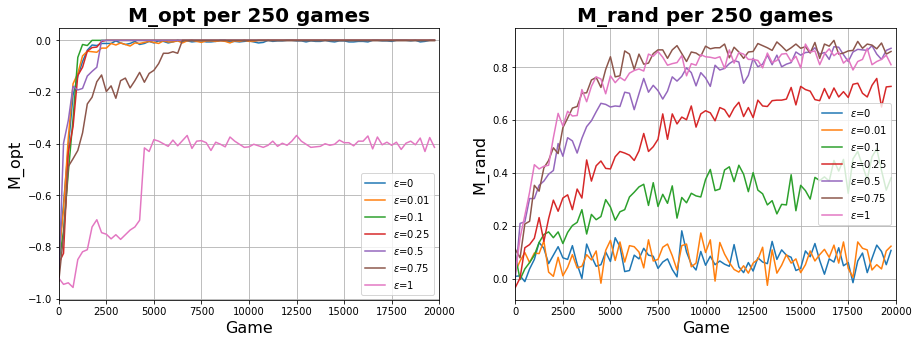

In [134]:
plot_m_values(stats_path='answers/Q4.npy', labels=[f'$\epsilon$={eps}' for eps in epsilons])

### Q7

In [141]:
epsilons = [0.01, 0.1, 0.2]
self_q_players = []

for eps in epsilons:
    qvalues = defaultdict(int)
    q_player1 = QPlayer(epsilon=eps, qvalues=qvalues, log_every=250, test_every=250)
    q_player2 = QPlayer(epsilon=eps, qvalues=qvalues, log_every=250, test_every=250)
    play(q_player1, q_player2, episodes=20000)
    self_q_players.append(q_player1)
    

save_stats(players=self_q_players, path='answers/Q7.npy')

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

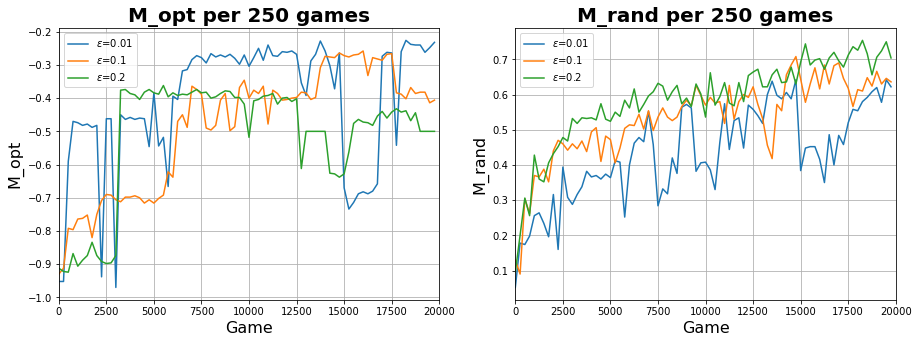

In [143]:
plot_m_values(stats_path='answers/Q7.npy', labels=[f'$\epsilon$={eps}' for eps in epsilons])

### Q8

In [145]:
EPS_MIN = 0.1
EPS_MAX = 0.8
n_stars = [1, 100, 1000, 10000, 40000]
self_n_star_players = []

for n_star in n_stars:
    get_epsilon = lambda n, n_star=n_star: max(EPS_MIN, EPS_MAX * (1 - n / n_star))
    qvalues = defaultdict(int)
    q_player1 = QPlayer(epsilon=eps, qvalues=qvalues, log_every=250, test_every=250)
    q_player2 = QPlayer(epsilon=eps, qvalues=qvalues, log_every=250, test_every=250)
    play(q_player1, q_player2, episodes=20000)
    self_n_star_players.append(q_player)
    
save_stats(players=self_n_star_players, path='answers/Q3.npy')



  0%|          | 0/20000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
plot_m_values(stats_path='answers/Q8.npy', labels=[f'n*={n_star}' for n_star in n_stars])

### Q10